In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.decomposition import PCA

from utils import load_mnist, load_fashion_mnist
from utils.training_ae import train_autoencoder
from utils.training_dec import train_dec
from utils import plot_ae_reconstructions, plot_all_reconstructions
from utils.plotting import plot_dec_centers

from utils.plotting import plot_pca
from utils.plotting import plot_umap
from utils.plotting import plot_losses

from models import Autoencoder, DEC

In [5]:
input_dim = 784
latent_dim = 10
n_clusters = 10
pretrain_epochs = 10
finetune_epochs = 10
learning_rate = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# data, labels = load_digits(return_X_y=True)
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)
#
# tensor_x = torch.Tensor(data).to(device)
#
# indices = torch.arange(len(tensor_x)).to(device)
# dataset = TensorDataset(tensor_x, indices)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
train_dataset, test_data = load_mnist()

# We flatten to (N, 784) and scale to [0, 1]
data = train_dataset.data.float() / 255.0
data = data.view(-1, 784)

labels = train_dataset.targets.numpy()
tensor_x = data.to(device)

# Create dataset with indices to map each batch to a full P distribution
# This allows us to compute P globally but train in batches
indices = torch.arange(len(tensor_x)).to(device)
dataset = TensorDataset(tensor_x, indices)
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Autoencoder Training

In [8]:
ae = Autoencoder(input_dim, latent_dim).to(device)

ae_optimizer = optim.Adam(ae.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

### Uncomment the lines below for custom training

In [10]:
# img_indices = [50563, 10910, 57965]
# ae_losses, images = train_autoencoder(
#     ae,
#     train_loader,
#     ae_optimizer,
#     mse_loss,
#     epochs=10,
#     image_indices=img_indices,
# )
#
# checkpoint = {
#     "model_state": ae.state_dict(),
#     "losses": ae_losses,
#     "images": images
# }
#
# torch.save(ae.state_dict(), "../checkpoints/autoencoder_mnist_param.pth")
# torch.save(checkpoint, "../checkpoints/autoencoder_mnist_full.pth")

### Load pretrained Autoencoder

In [9]:
ae.load_state_dict(torch.load("../checkpoints/autoencoder_mnist.pth"))

checkpoint = torch.load("../checkpoints/autoencoder_full.pth", map_location="cpu")
# ae.load_state_dict(checkpoint["model_state"])
ae_losses = checkpoint["losses"]
images = checkpoint["images"]

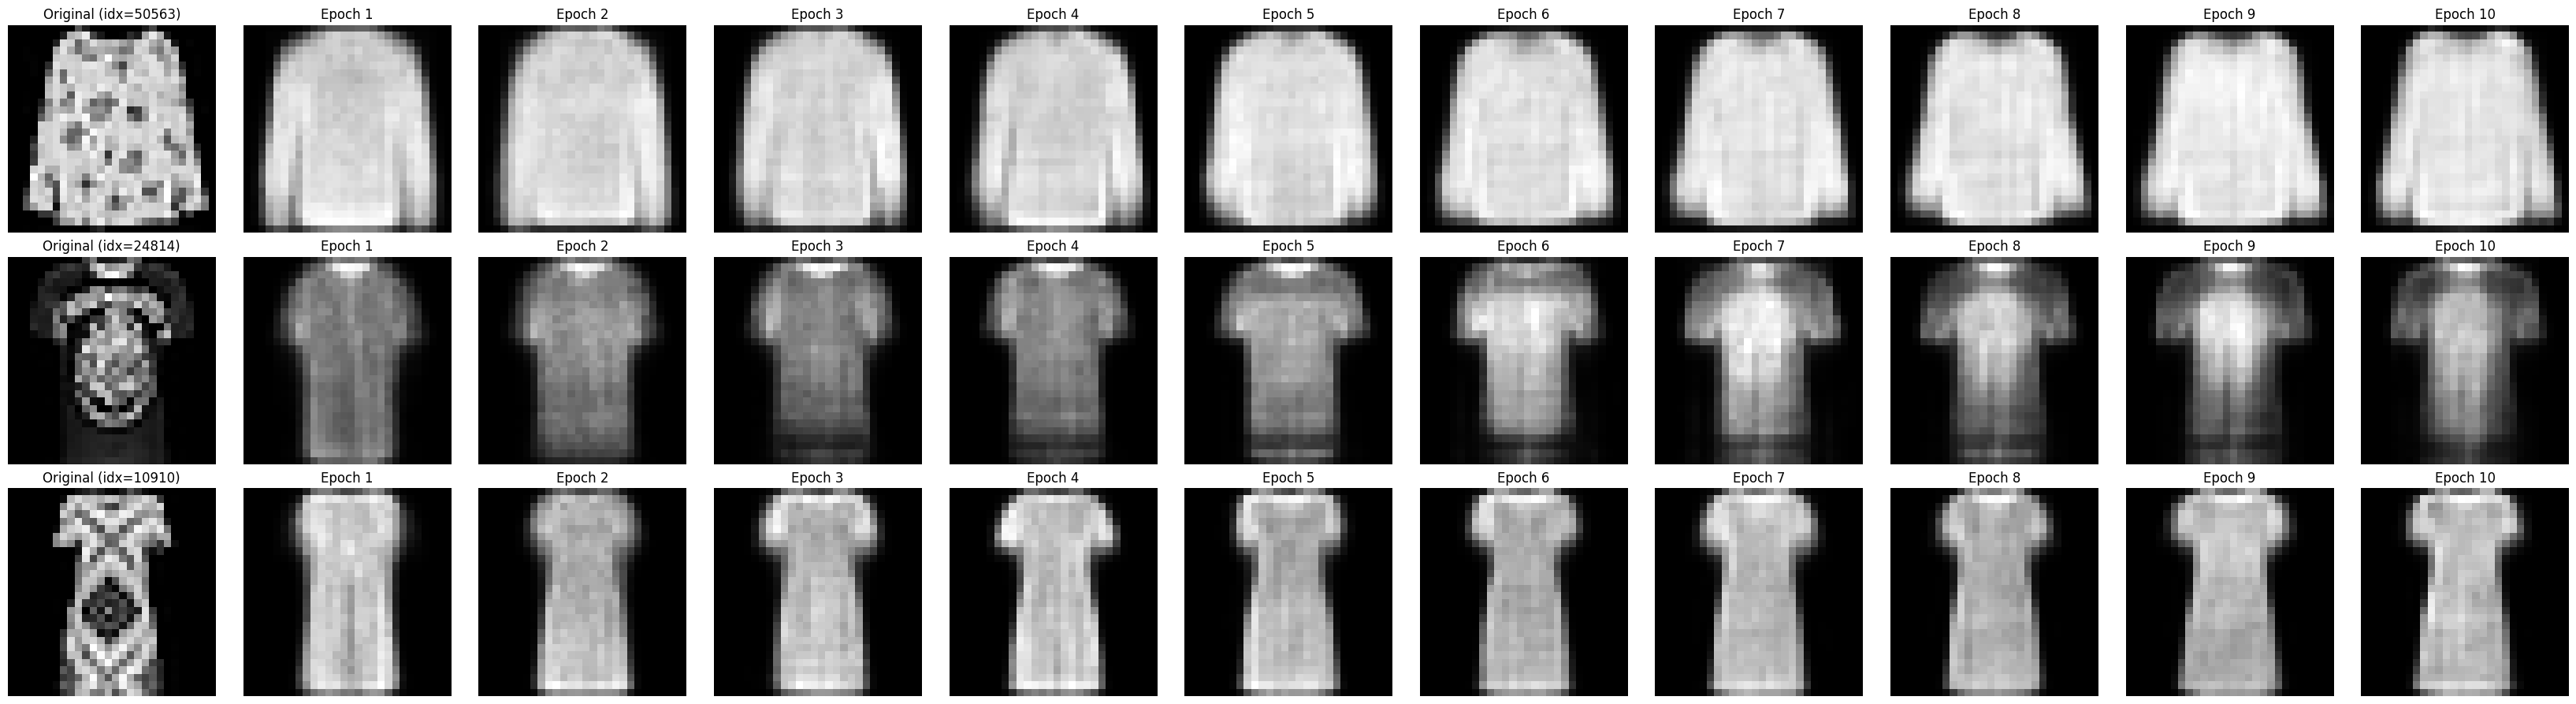

In [10]:
plot_all_reconstructions(images)

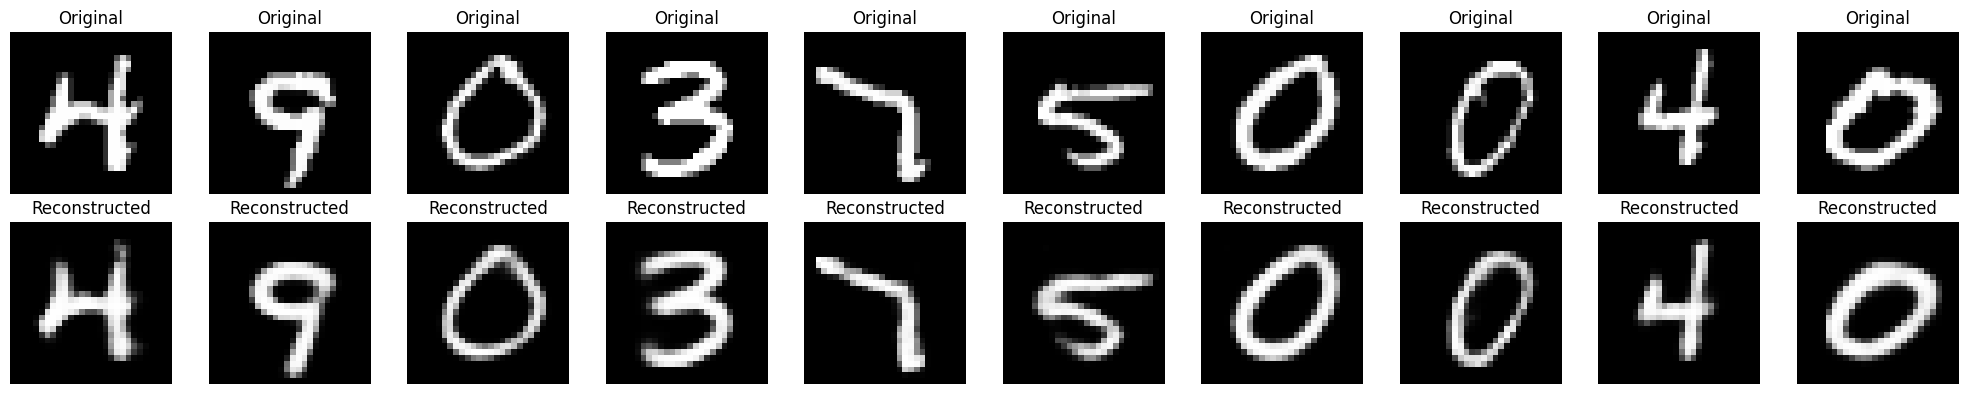

In [11]:
plot_ae_reconstructions(
    ae,
    train_dataset,
    n=10,
    device=device
)

# DEC Training

In [12]:
dec = DEC(ae, n_clusters, latent_dim).to(device)
# dec.initialize_centers(train_loader, device)

dec_optimizer = optim.SGD(dec.parameters(), lr=learning_rate, momentum=0.9)
kl_loss_fn = nn.KLDivLoss(reduction='batchmean')

### Uncomment the lines below for custom training


In [13]:
# dec_losses = train_dec(
#     dec,
#     train_loader,
#     dec_optimizer,
#     kl_loss_fn,
#     tensor_x,
#     epochs=250,
#     device=device,
# )

Epoch 1/250: average loss = 0.0610
Epoch 2/250: average loss = 0.1591
Epoch 3/250: average loss = 0.2218
Epoch 4/250: average loss = 0.2538
Epoch 5/250: average loss = 0.2622
Epoch 6/250: average loss = 0.2581
Epoch 7/250: average loss = 0.2510
Epoch 8/250: average loss = 0.2421
Epoch 9/250: average loss = 0.2328
Epoch 10/250: average loss = 0.2234
Epoch 11/250: average loss = 0.2136
Epoch 12/250: average loss = 0.2056
Epoch 13/250: average loss = 0.1976
Epoch 14/250: average loss = 0.1910
Epoch 15/250: average loss = 0.1848
Epoch 16/250: average loss = 0.1784
Epoch 17/250: average loss = 0.1737
Epoch 18/250: average loss = 0.1689
Epoch 19/250: average loss = 0.1642
Epoch 20/250: average loss = 0.1596
Epoch 21/250: average loss = 0.1554
Epoch 22/250: average loss = 0.1521
Epoch 23/250: average loss = 0.1486
Epoch 24/250: average loss = 0.1449
Epoch 25/250: average loss = 0.1413
Epoch 26/250: average loss = 0.1391
Epoch 27/250: average loss = 0.1354
Epoch 28/250: average loss = 0.1332
E

In [121]:
# torch.save(dec.state_dict(), "../checkpoints/dec_mnist.pth")

### Load pretrained Autoencoder

In [20]:
dec.load_state_dict(torch.load("../checkpoints/dec_mnist.pth"))
dec.eval()

DEC(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2000, out_features=10, bias=True)
  )
)

# Model evaluation

In [14]:
dec.eval()
with torch.no_grad():
    print(tensor_x.shape)
    q_final, full_z_np = dec(tensor_x)
    full_z_np = full_z_np.cpu().numpy()
    pred_labels = torch.argmax(q_final, dim=1).cpu().numpy()

ari = adjusted_rand_score(labels, pred_labels)
nmi = normalized_mutual_info_score(labels, pred_labels)

print(f"Adjusted Rand Score (ARI): {ari:.4f}")
print(f"Normalized mutual information: {nmi:.4f}")
print(f"Predicted Cluster Counts: {np.bincount(pred_labels)}")

torch.Size([60000, 784])
Adjusted Rand Score (ARI): 0.7682
Normalized mutual information: 0.8229
Predicted Cluster Counts: [5808 4050 6085 5444 6560 5596 6116 8113 6302 5926]


# Plot results

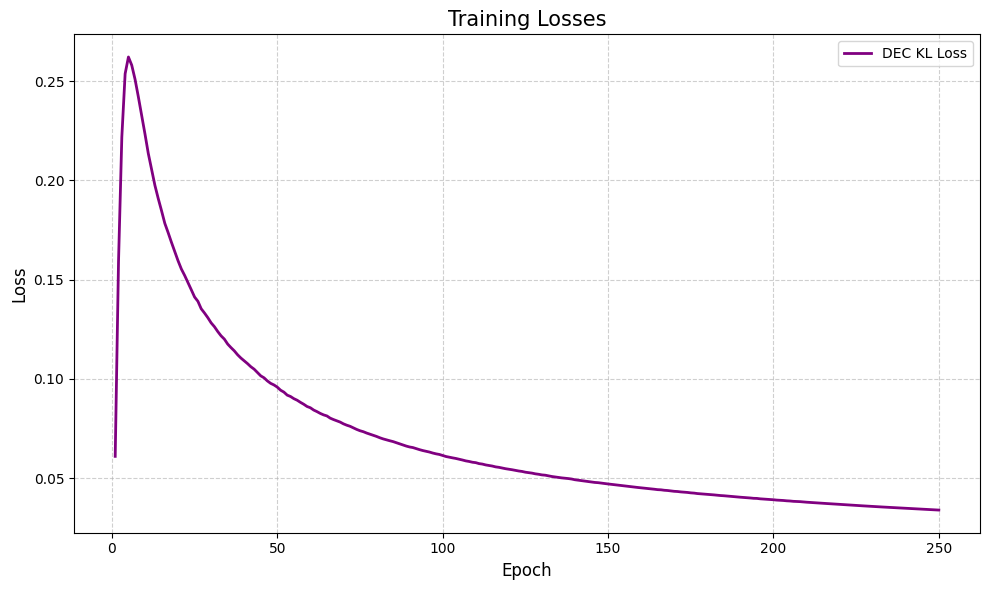

In [15]:
plot_losses(dec_losses=dec_losses)

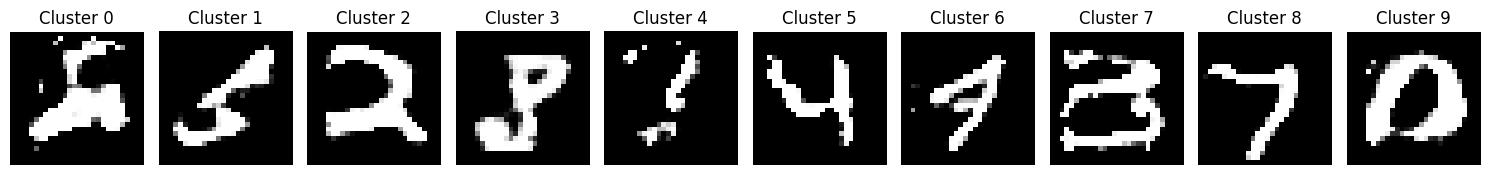

In [16]:
plot_dec_centers(dec, ae)

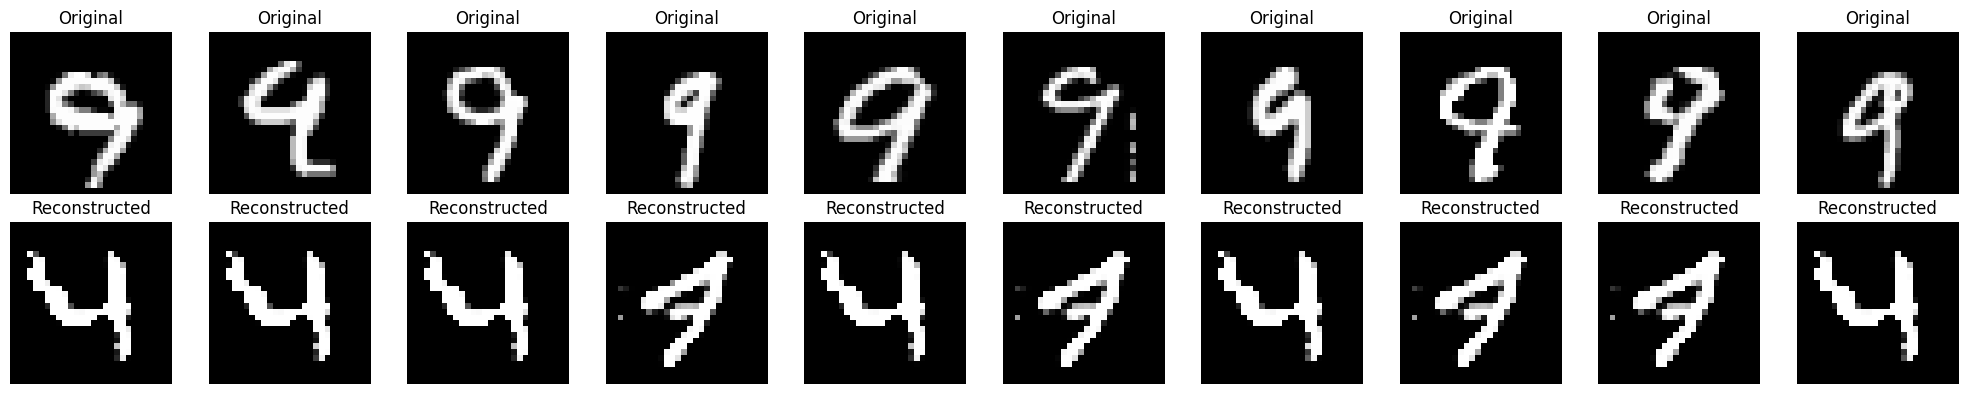

In [17]:
indices = []

while True:
    idx = torch.randint(len(train_dataset), size=(1,)).item()

    img, label = train_dataset[idx]
    if label == 9:
        indices.append(idx)

    if len(indices) == 10:
        break

plot_ae_reconstructions(ae, train_dataset, indices=indices)

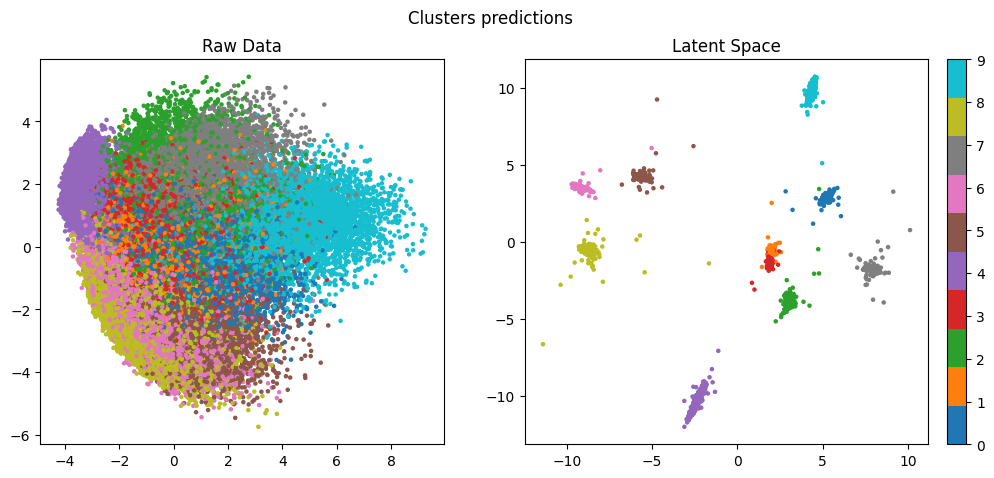

In [18]:
plot_pca(data, full_z_np, pred_labels, title='Clusters predictions')

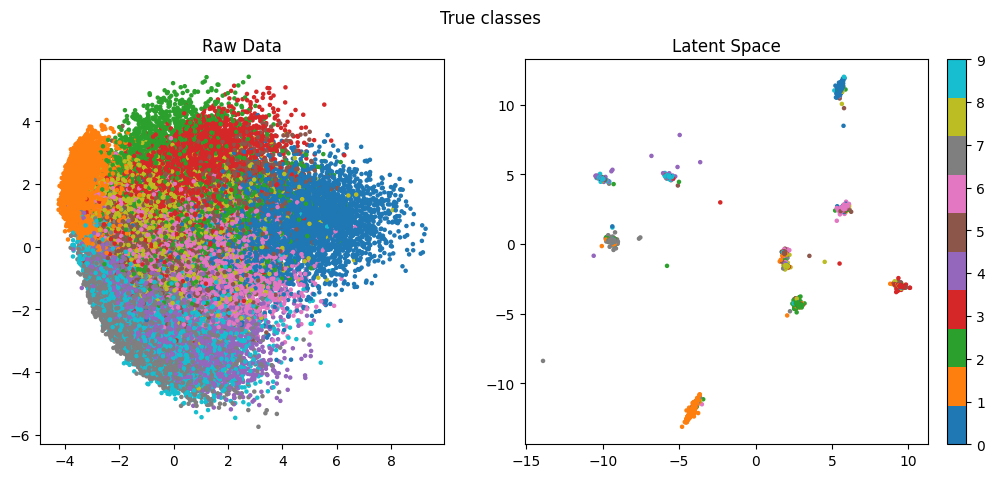

In [25]:
plot_pca(data, full_z_np, labels, title='True classes')

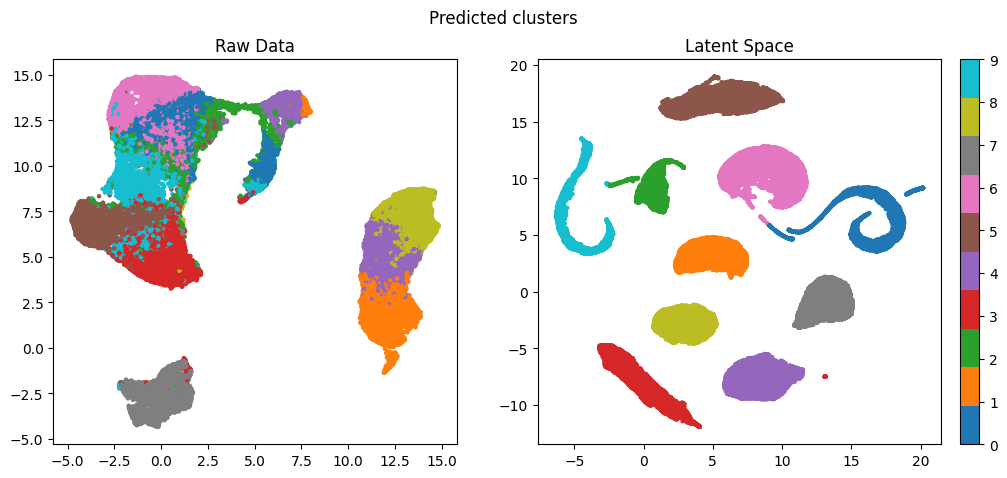

In [119]:
plot_umap(data, full_z_np, pred_labels, title='Predicted clusters')

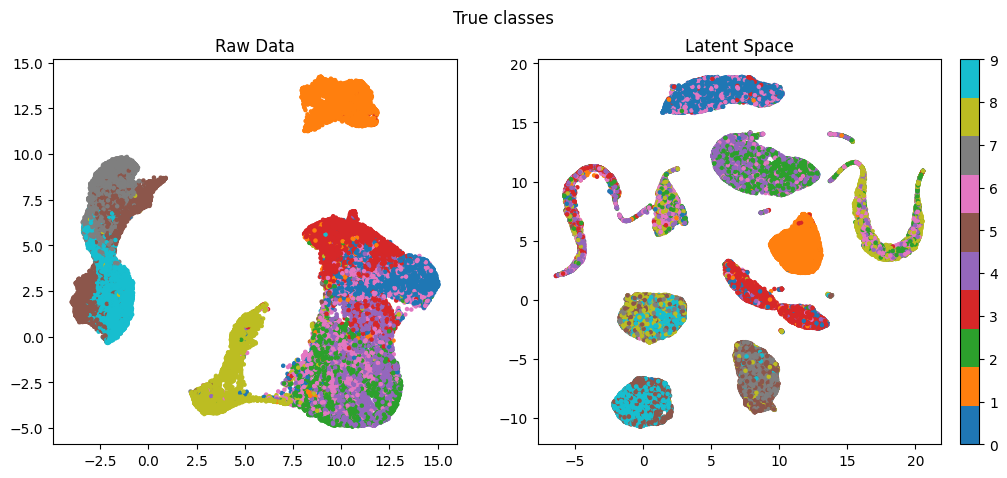

In [120]:
plot_umap(data, full_z_np, labels, title='True classes')